In [17]:
import cv2, json
import numpy as np
import torch
import pytorch_model_summary

import matplotlib.pyplot as plt
%matplotlib inline

import utils.config as config

In [2]:
# Load test data, estimation results, and label.
dataset = 'SMAP'
test_data = np.load(config.TEST_DATASET[dataset])
test_label = np.load(config.TEST_LABEL[dataset])

with open('data/'+dataset+'_test_channel.json', 'r') as f:
    test_divisions = json.load(f)

In [3]:
output_values = np.load('logs/221203154202/state_dict_results.npy')
# output_values = np.load('logs/221203154202/state_dict_step_90000_results.npy')

In [4]:
print(test_label.shape)
print(output_values.shape)

(427617,)
(427617, 1)


In [5]:
def ewma(series, weighting_factor=0.9):
    current_factor = 1 - weighting_factor
    _ewma = series.copy()
    for i in range(1, len(_ewma)):
        _ewma[i] = _ewma[i-1] * weighting_factor + _ewma[i] * current_factor
    return _ewma

In [6]:
smoothed_values = ewma(output_values[:, 0], 0.9)

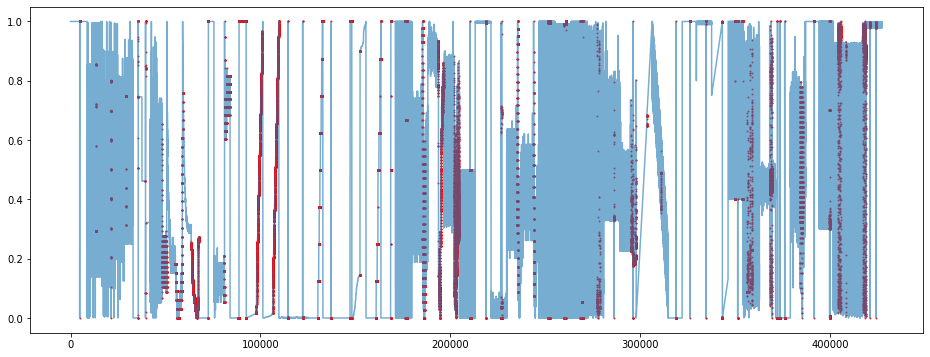

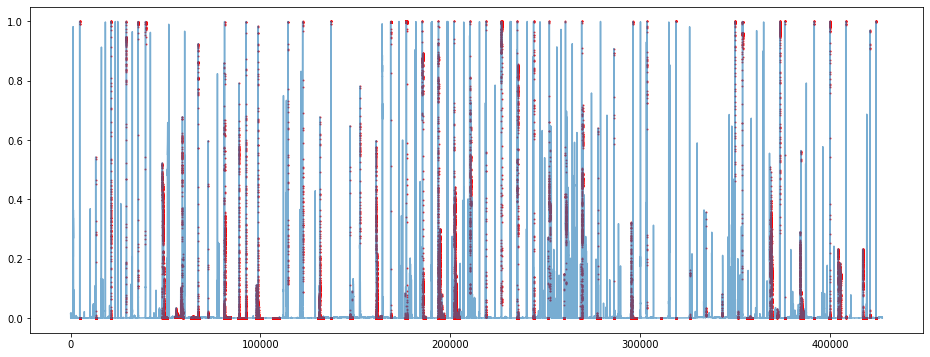

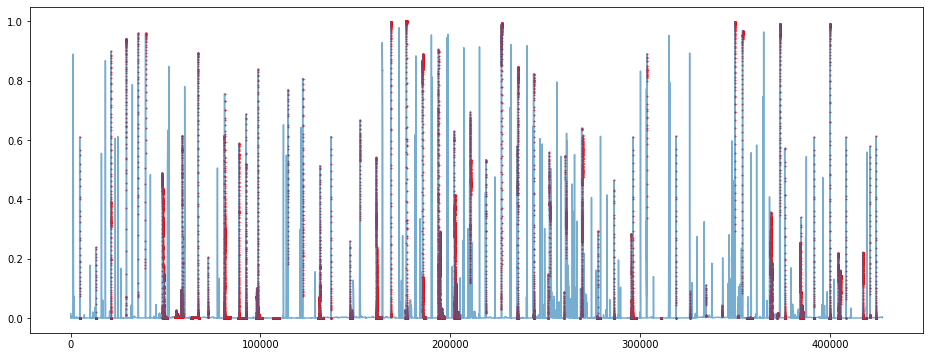

In [12]:
index = (0, 427617)# test_divisions[5]  # (30000, 40000)
label = test_label[index[0]:index[1]]

plt.figure(figsize=(16, 6))
plt.plot(test_data[index[0]:index[1], 0], alpha=0.6)
plt.scatter(np.arange(index[1]-index[0])[label], test_data[index[0]:index[1]][label, 0],
            c='r', s=1, alpha=0.8)
plt.show()

# for i in range(25):
#     plt.figure(figsize=(16, 2))
#     plt.plot(test_data[index[0]:index[1], i], alpha=0.6)
#     plt.show()

plt.figure(figsize=(16, 6))
plt.plot(output_values[index[0]:index[1], 0], alpha=0.6)
plt.scatter(np.arange(index[1]-index[0])[label], output_values[index[0]:index[1]][label, 0],
            c='r', s=1, alpha=0.8)
plt.show()

plt.figure(figsize=(16, 6))
plt.plot(smoothed_values[index[0]:index[1]], alpha=0.6)
plt.scatter(np.arange(index[1]-index[0])[label], smoothed_values[index[0]:index[1]][label],
            c='r', s=1, alpha=0.8)
plt.show()

In [9]:
# Simple evaluation function
def evaluate(gt, pred, rates):
    n_tops = (rates * len(gt)).astype(int)
    anomaly_args = np.argwhere(gt).flatten()
    
    anomaly = []
    sorted_values = np.sort(pred)[::-1]
    
    for n_top, rate in zip(n_tops, rates):
        thres = sorted_values[n_top]
        anomaly_pts = np.argwhere(pred > thres).flatten()
        terms = anomaly_pts[1:] - anomaly_pts[:-1]
        terms = terms > 1
        
        sequence_args = np.argwhere(terms).flatten() + 1
        sequence_length = list(sequence_args[1:] - sequence_args[:-1])
        sequence_args = list(sequence_args)
        
        sequence_args.insert(0, 0)
        if len(sequence_args) > 1:
            sequence_length.insert(0, sequence_args[1])
        sequence_length.append(len(anomaly_args) - sequence_args[-1])
        
        sequence_args = anomaly_pts[sequence_args]
        _sequence_args = sequence_args + np.array(sequence_length)
        
        anomaly.append(np.array((sequence_args, _sequence_args)))
        
    terms = anomaly_args[1:] - anomaly_args[:-1]
    terms = terms > 1

    sequence_args = np.argwhere(terms).flatten() + 1
    sequence_length = list(sequence_args[1:] - sequence_args[:-1])
    sequence_args = list(sequence_args)

    sequence_args.insert(0, 0)
    if len(sequence_args) > 1:
        sequence_length.insert(0, sequence_args[1])
    sequence_length.append(len(anomaly_args) - sequence_args[-1])

    sequence_args = anomaly_args[sequence_args]
    anomaly_label_seq = np.transpose(np.array((sequence_args, sequence_args + np.array(sequence_length))))
    
#     print('# anomalies :', len(anomaly_label_seq))
#     for _seq in anomaly_label_seq:
#         print(_seq, ', length : ', _seq[1]-_seq[0], sep='')
#     print()
    
    precision = []
    recall = []
    f1 = []
    
    for seq in anomaly:
        overlap_table = (seq[[0]] < anomaly_label_seq[:, [1]]) & (seq[[1]] > anomaly_label_seq[:, [0]])
        overlap_table = overlap_table.astype(int)

        _precision = overlap_table.sum(axis=0) > 0
        _recall = overlap_table.sum(axis=1) > 0
        
        TP = len(_recall[_recall])
        FN = len(_recall) - TP
        FP = len(_precision) - len(_precision[_precision])
        
        prec = TP / (TP + FP)
        rec = TP / (TP + FN)
        _f1 = 2 * prec * rec / (prec + rec)
        
        precision.append(prec)
        recall.append(rec)
        f1.append(_f1)
        
#         precision.append(len(_precision[_precision]) / len(_precision))
#         recall.append(len(_recall[_recall]) / len(_recall))
        
    for rate, prec, rec, _f1 in zip(rates, precision, recall, f1):
        print('threshold : {0:.02f}%,\tprecision : {1:.02f}%,\trecall : {2:.02f}%, \tf1 : {3:.02f}%'.format(rate*100, prec*100, rec*100, _f1*100), sep='')

In [10]:
evaluate(test_label, output_values[:, 0], np.arange(0.001, 0.031, 0.001))

threshold : 0.10%,	precision : 55.77%,	recall : 42.65%, 	f1 : 48.33%
threshold : 0.20%,	precision : 49.25%,	recall : 48.53%, 	f1 : 48.89%
threshold : 0.30%,	precision : 43.04%,	recall : 50.00%, 	f1 : 46.26%
threshold : 0.40%,	precision : 35.79%,	recall : 50.00%, 	f1 : 41.72%
threshold : 0.50%,	precision : 33.01%,	recall : 50.00%, 	f1 : 39.77%
threshold : 0.60%,	precision : 32.69%,	recall : 50.00%, 	f1 : 39.53%
threshold : 0.70%,	precision : 28.68%,	recall : 54.41%, 	f1 : 37.56%
threshold : 0.80%,	precision : 27.08%,	recall : 57.35%, 	f1 : 36.79%
threshold : 0.90%,	precision : 26.28%,	recall : 60.29%, 	f1 : 36.61%
threshold : 1.00%,	precision : 24.58%,	recall : 64.71%, 	f1 : 35.63%
threshold : 1.10%,	precision : 23.44%,	recall : 66.18%, 	f1 : 34.62%
threshold : 1.20%,	precision : 21.63%,	recall : 66.18%, 	f1 : 32.61%
threshold : 1.30%,	precision : 23.27%,	recall : 69.12%, 	f1 : 34.81%
threshold : 1.40%,	precision : 23.08%,	recall : 70.59%, 	f1 : 34.78%
threshold : 1.50%,	precision : 23.

In [11]:
evaluate(test_label, smoothed_values, np.arange(0.001, 0.051, 0.001))

threshold : 0.10%,	precision : 89.47%,	recall : 25.00%, 	f1 : 39.08%
threshold : 0.20%,	precision : 82.61%,	recall : 27.94%, 	f1 : 41.76%
threshold : 0.30%,	precision : 79.17%,	recall : 27.94%, 	f1 : 41.30%
threshold : 0.40%,	precision : 57.58%,	recall : 27.94%, 	f1 : 37.62%
threshold : 0.50%,	precision : 47.62%,	recall : 29.41%, 	f1 : 36.36%
threshold : 0.60%,	precision : 41.82%,	recall : 33.82%, 	f1 : 37.40%
threshold : 0.70%,	precision : 42.37%,	recall : 36.76%, 	f1 : 39.37%
threshold : 0.80%,	precision : 46.88%,	recall : 44.12%, 	f1 : 45.45%
threshold : 0.90%,	precision : 41.77%,	recall : 48.53%, 	f1 : 44.90%
threshold : 1.00%,	precision : 37.66%,	recall : 42.65%, 	f1 : 40.00%
threshold : 1.10%,	precision : 37.80%,	recall : 45.59%, 	f1 : 41.33%
threshold : 1.20%,	precision : 38.64%,	recall : 50.00%, 	f1 : 43.59%
threshold : 1.30%,	precision : 36.36%,	recall : 52.94%, 	f1 : 43.11%
threshold : 1.40%,	precision : 36.73%,	recall : 52.94%, 	f1 : 43.37%
threshold : 1.50%,	precision : 39.

In [13]:
def point_adjustment2(gt, pr, anomaly_rate=0.05, adjust=True):
    # get anomaly intervals
    gt_aug = np.concatenate([np.zeros(1), gt, np.zeros(1)])
    gt_diff = gt_aug[1:] - gt_aug[:-1]

    begin = np.where(gt_diff == 1)[0]
    end = np.where(gt_diff == -1)[0]

    intervals = np.stack([begin, end], axis=1)

    # quantile cut
    pa = pr.copy()
    q = np.quantile(pa, 1-anomaly_rate)
    pa = (pa > q).astype(int)

    # pa
    if adjust:
        for s, e in intervals:
            interval = slice(s, e)
            if pa[interval].sum() > 0:
                pa[interval] = 1

    # confusion matrix
    TP = (gt * pa).sum()
    TN = ((1 - gt) * (1 - pa)).sum()
    FP = ((1 - gt) * pa).sum()
    FN = (gt * (1 - pa)).sum()

    assert (TP + TN + FP + FN) == len(gt)

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2*precision*recall/(precision+recall)
    
#     print(f"anomaly rate: {anomaly_rate:.3f} | precision: {precision:.5f} | recall: {recall:.5f} | F1-score: {f1_score:.5f}")

    return precision, recall, f1_score

In [14]:
best_eval = (0, 0, 0)
best_rate = 0

for rate in np.arange(0.001, 0.301, 0.001):
    evaluation = point_adjustment2(test_label, output_values[:, 0], rate, True)
    if evaluation[2] > best_eval[2]:
        best_eval = evaluation
        best_rate = rate

print(f"anomaly rate: {best_rate:.3f} | precision: {best_eval[0]:.5f} | recall: {best_eval[1]:.5f} | F1-score: {best_eval[2]:.5f}")

anomaly rate: 0.028 | precision: 0.89744 | recall: 0.91206 | F1-score: 0.90469


In [15]:
best_eval = (0, 0, 0)
best_rate = 0

for rate in np.arange(0.001, 0.301, 0.001):
    evaluation = point_adjustment2(test_label, output_values[:, 0], rate, False)
    if evaluation[2] > best_eval[2]:
        best_eval = evaluation
        best_rate = rate

print(f"anomaly rate: {best_rate:.3f} | precision: {best_eval[0]:.5f} | recall: {best_eval[1]:.5f} | F1-score: {best_eval[2]:.5f}")

anomaly rate: 0.133 | precision: 0.35055 | recall: 0.36451 | F1-score: 0.35739


In [16]:
best_eval = (0, 0, 0)
best_rate = 0

for rate in np.arange(0.001, 0.301, 0.001):
    evaluation = point_adjustment2(test_label, smoothed_values, rate, False)
    if evaluation[2] > best_eval[2]:
        best_eval = evaluation
        best_rate = rate

print(f"anomaly rate: {best_rate:.3f} | precision: {best_eval[0]:.5f} | recall: {best_eval[1]:.5f} | F1-score: {best_eval[2]:.5f}")

anomaly rate: 0.152 | precision: 0.33227 | recall: 0.39486 | F1-score: 0.36087


In [20]:
# Summary model.
model = torch.load('logs/221203154202/model.pt', map_location='cpu')
print(pytorch_model_summary.summary(model, torch.zeros(1, 2048, 25), show_input=False))

----------------------------------------------------------------------------
           Layer (type)        Output Shape         Param #     Tr. Param #
               Linear-1       [1, 512, 512]          51,712          51,712
   TransformerEncoder-2       [1, 512, 512]      37,926,816      37,926,816
               Linear-3      [1, 512, 2048]       1,050,624       1,050,624
                 GELU-4      [1, 512, 2048]               0               0
               Linear-5         [1, 512, 4]           8,196           8,196
Total params: 39,037,348
Trainable params: 39,037,348
Non-trainable params: 0
----------------------------------------------------------------------------


In [2]:
# Load entire data.
dataset = 'SMD'
train_data = np.load(config.TRAIN_DATASET[dataset])
test_data = np.load(config.TEST_DATASET[dataset])
test_label = np.load(config.TEST_LABEL[dataset])

with open('data/'+dataset+'_test_channel.json', 'r') as f:
    test_divisions = json.load(f)

In [3]:
# Check data shapes.
print(train_data.shape)
print(test_data.shape)
print(test_label.shape)

(708405, 38)
(708420, 38)
(708420,)


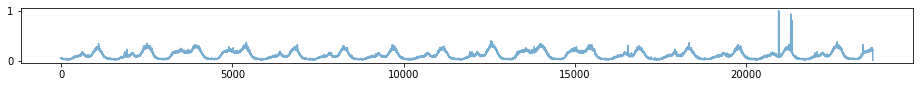

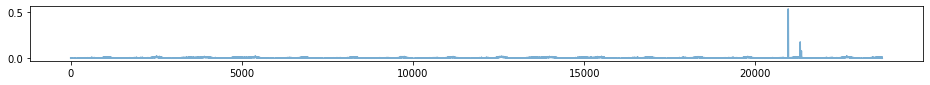

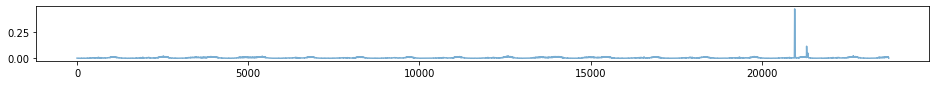

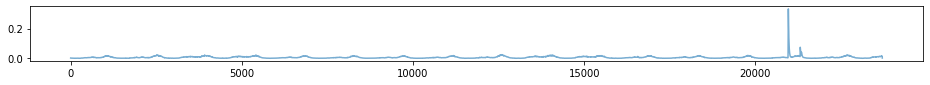

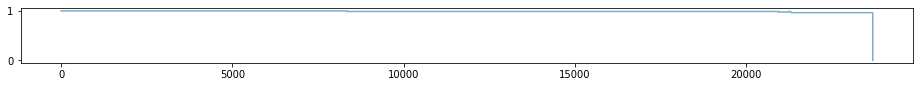

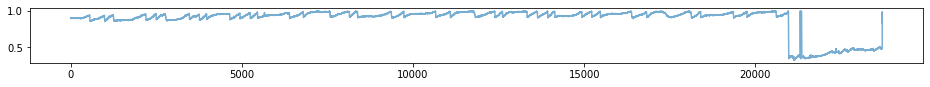

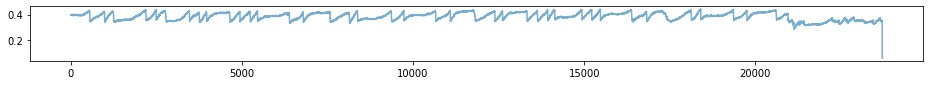

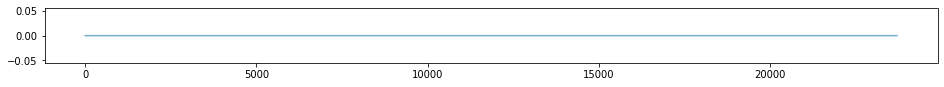

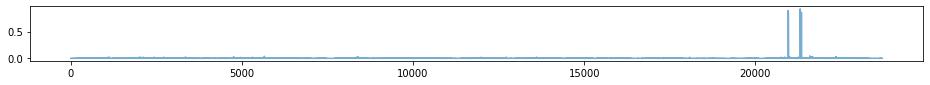

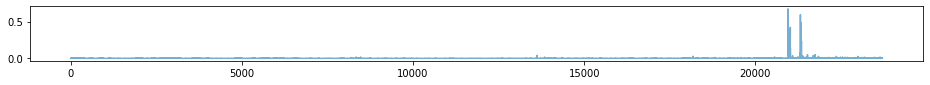

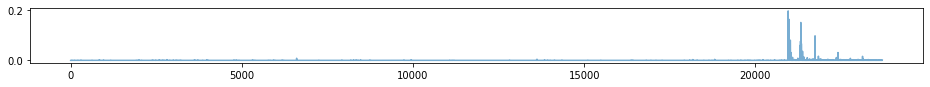

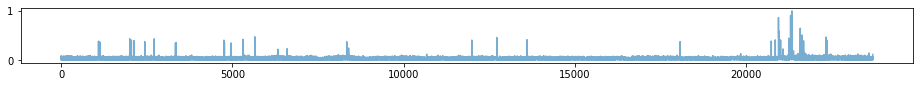

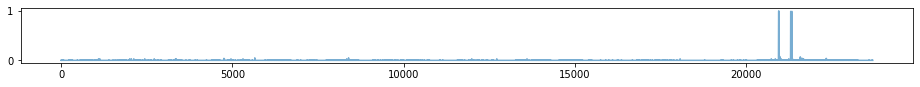

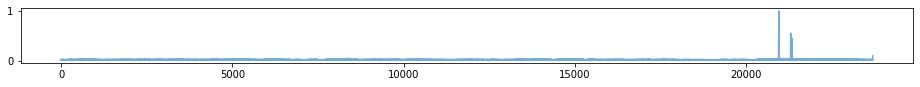

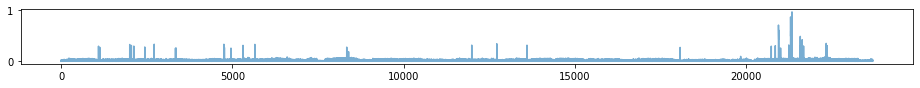

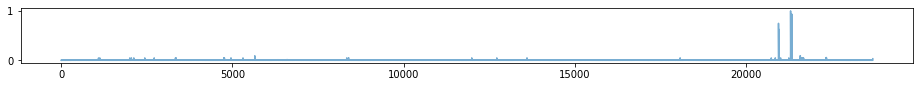

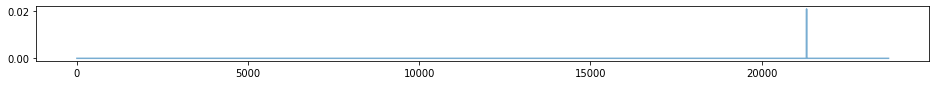

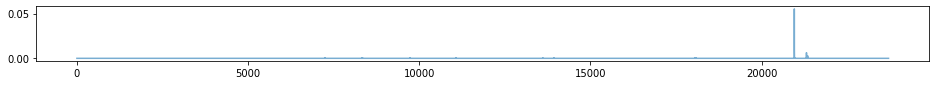

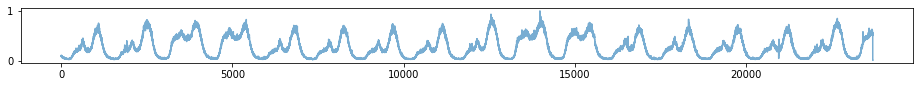

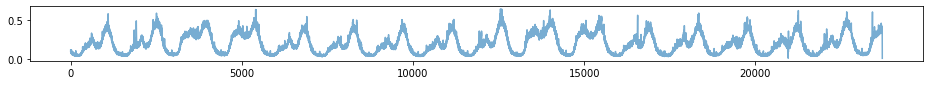

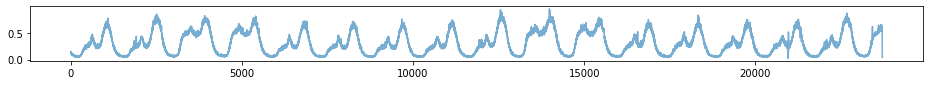

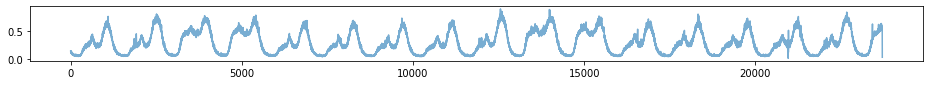

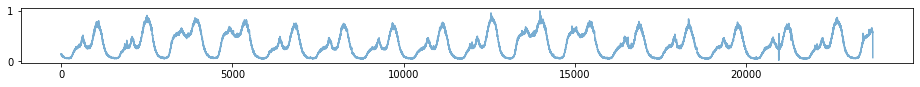

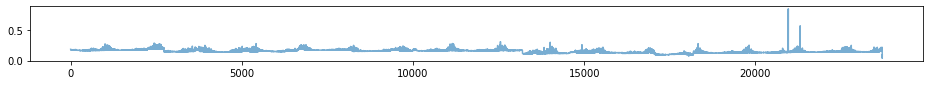

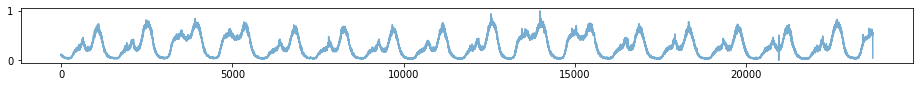

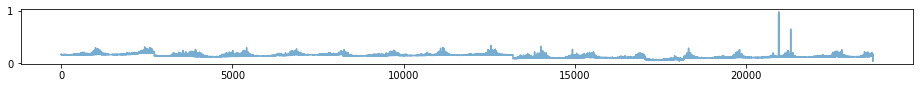

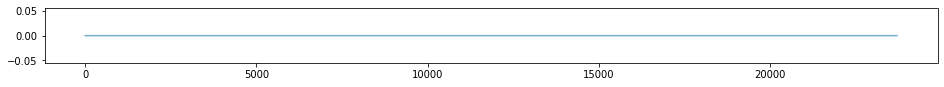

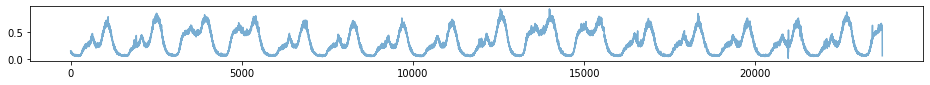

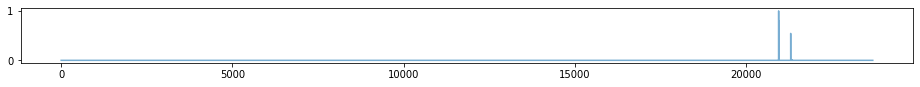

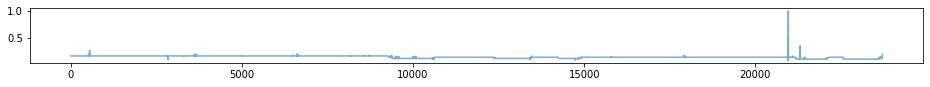

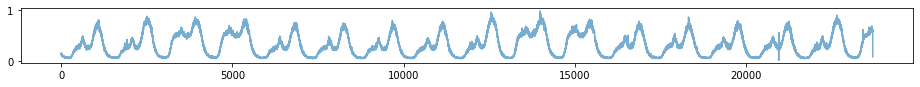

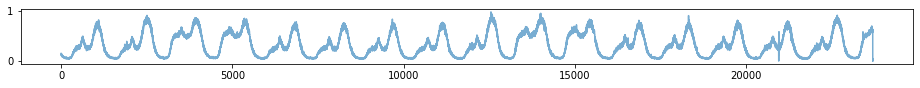

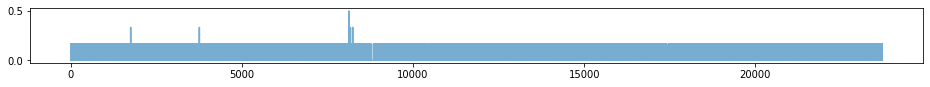

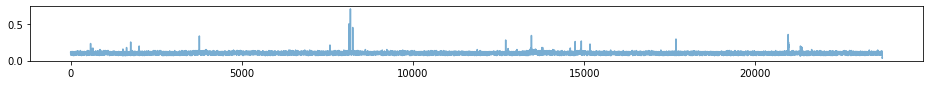

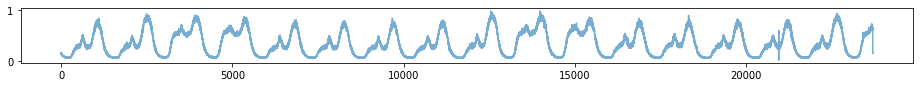

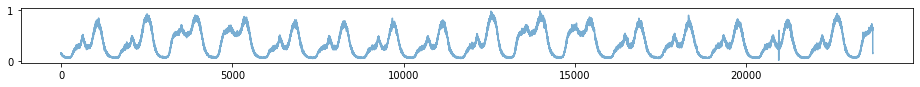

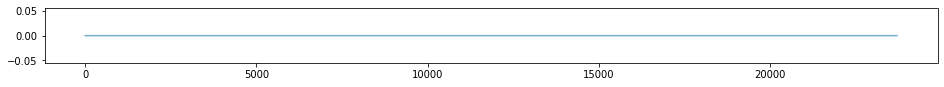

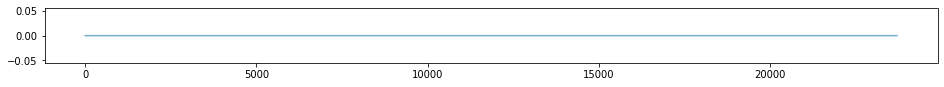

In [10]:
# Visualize train data.
index = test_divisions[3]
label = train_data[index[0]:index[1]].astype(bool)

for i in range(len(train_data[0])):
    plt.figure(figsize=(16, 1))
    plt.plot(train_data[index[0]:index[1], i], alpha=0.6)
    plt.show()

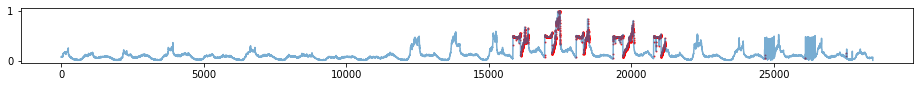

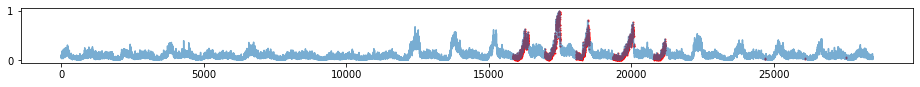

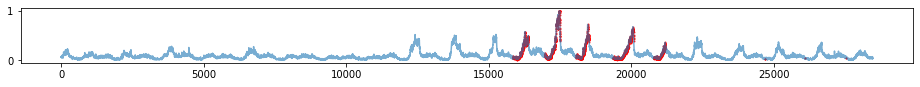

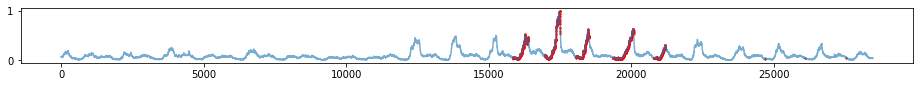

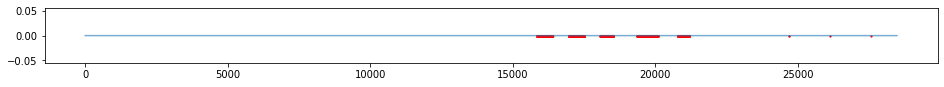

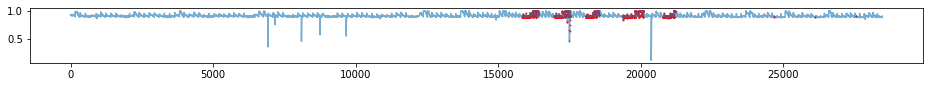

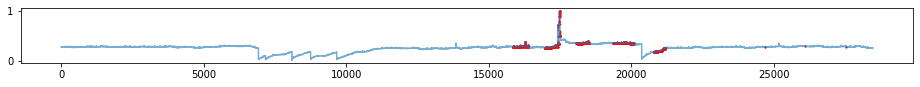

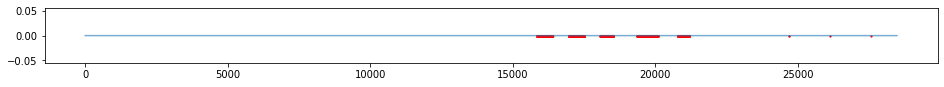

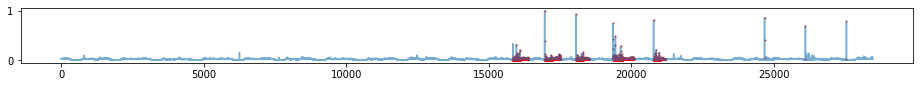

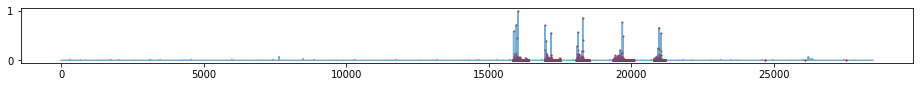

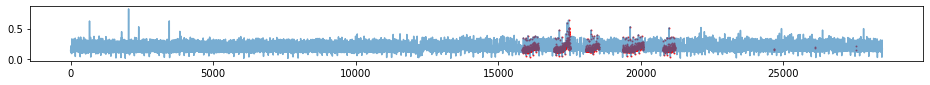

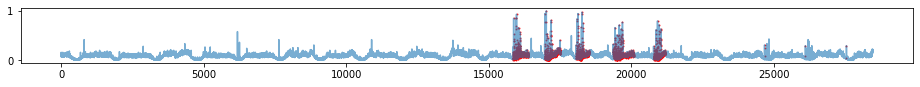

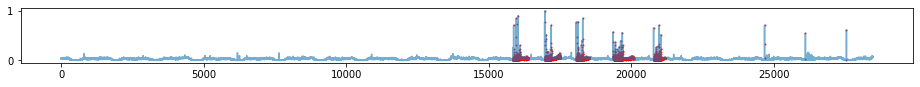

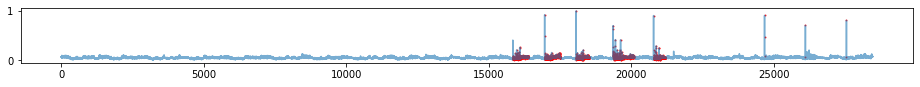

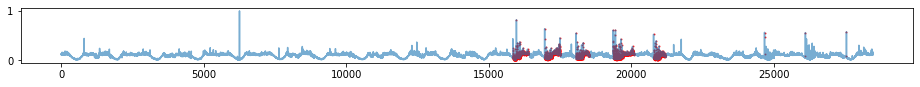

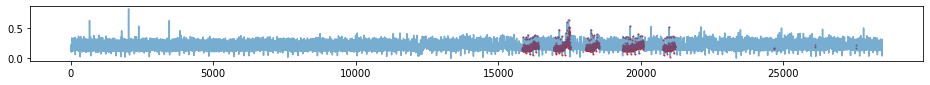

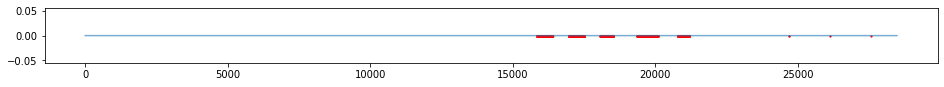

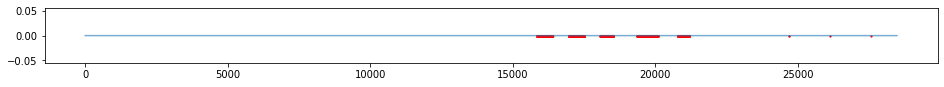

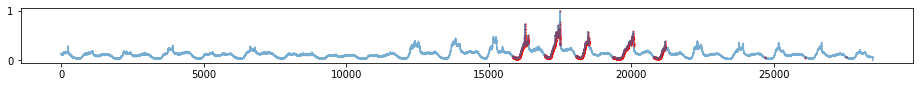

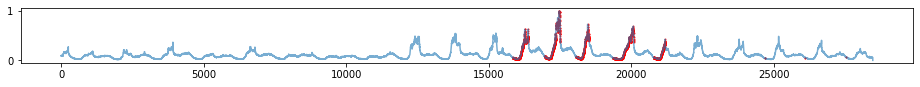

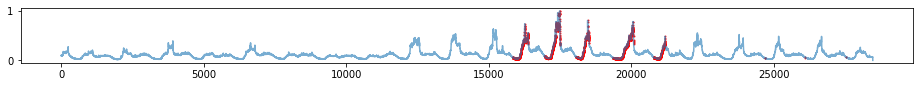

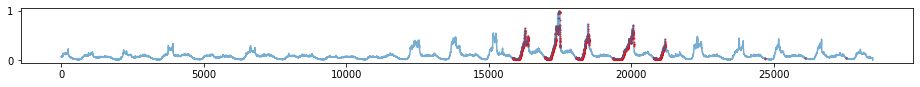

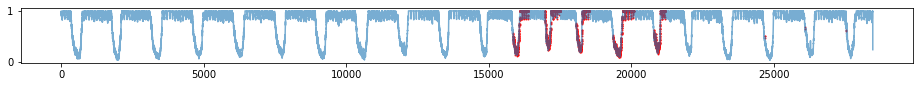

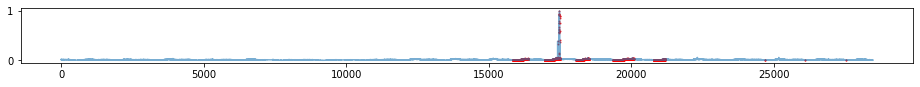

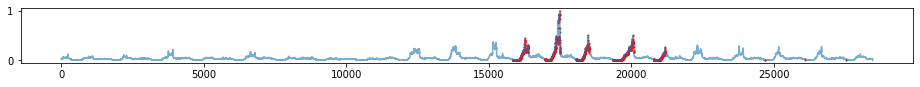

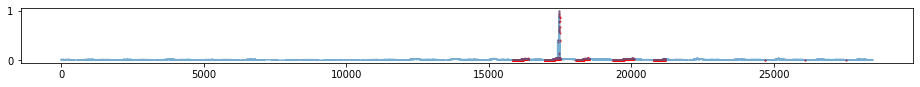

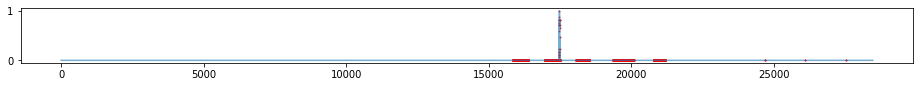

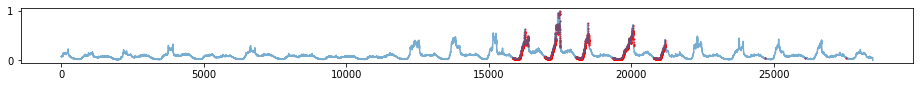

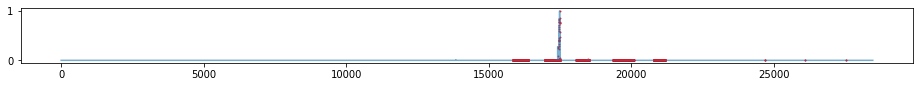

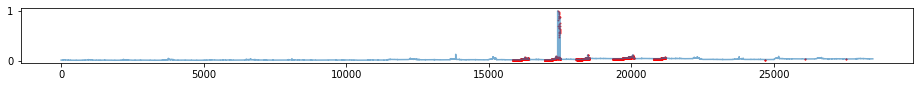

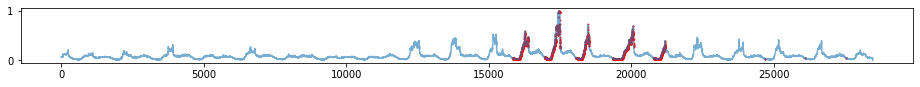

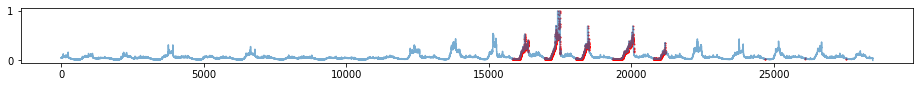

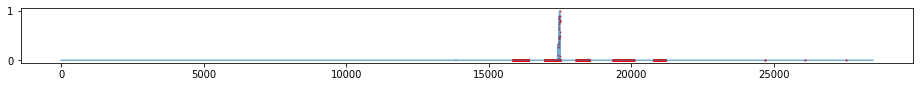

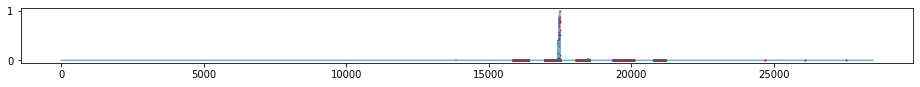

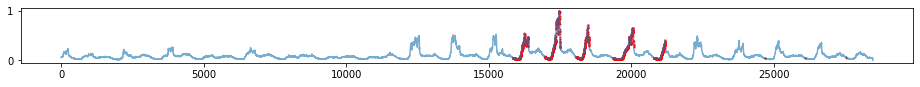

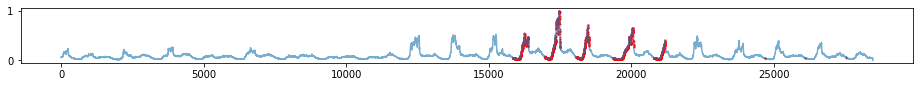

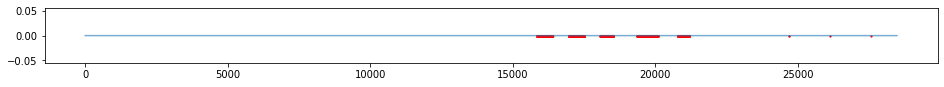

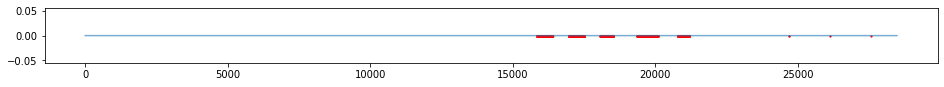

In [22]:
# Visualize test data.
index = test_divisions[0]
label = test_label[index[0]:index[1]].astype(bool)

for i in range(len(train_data[0])):
    plt.figure(figsize=(16, 1))
    plt.plot(test_data[index[0]:index[1], i], alpha=0.6)
    plt.scatter(np.arange(index[1]-index[0])[label], test_data[index[0]:index[1]][label, i],
                c='r', s=1, alpha=0.8)
    plt.show()